# Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
from functools import partial
import sklearn

In [3]:
from fastai import *
from fastai.vision import *

# Load and Prepare Data

### Doulble check GS images

In [4]:
gs_df = pd.read_csv('GS.csv')[['dsName', 'sumFormula', 'adduct', 'type']]
gs_df['dsName'] = gs_df.dsName.map(lambda name: name.replace('/', '_'))
gs_df['ion'] = gs_df.sumFormula + gs_df.adduct
gs_df.drop(labels=['sumFormula', 'adduct'], axis=1, inplace=True)
gs_df.sort_values(by=['dsName', 'type', 'ion'], inplace=True)
gs_df.reset_index(drop=True, inplace=True)
gs_df.head()

,dsName,type,ion
0,100um_noM2_001_Recal,off,C14H20N6O5S+H
1,100um_noM2_001_Recal,off,C15H19NO10+H
2,100um_noM2_001_Recal,off,C15H26N2O12+H
3,100um_noM2_001_Recal,off,C16H16O11S+Na
4,100um_noM2_001_Recal,off,C16H19N3O5S+H


In [5]:
gs_path = Path('./GS/raw_images'); gs_path

PosixPath('GS/raw_images')

In [6]:
rows = []
for ds_path in gs_path.iterdir():
    ds_name = ds_path.name
    for t in ['on', 'off']:
        for image_path in (ds_path / t).iterdir():
            ion = image_path.name.split('.')[0]
            rows.append([ds_name, t, ion])
iso_image_df = (pd.DataFrame(rows, columns=['dsName', 'type', 'ion'])
                .sort_values(by=['dsName', 'type', 'ion'])
                .reset_index(drop=True))

In [7]:
np.all(gs_df == iso_image_df)

True

### Prepare Dataframe for Fastai Loader

In [8]:
len(list(gs_path.iterdir()))

87

In [9]:
row_list = []
for ds_path in gs_path.iterdir():
    for cl in ['on', 'off']:
        for p in (ds_path / cl).iterdir():
            row_list.append([str(p), ds_path.name, cl])

df = pd.DataFrame(row_list, columns=['name', 'group', 'label'])
df.shape

(23238, 3)

In [10]:
df.head()

,name,group,label
0,GS/raw_images/DESI porcine kidney interface re...,DESI porcine kidney interface region,on
1,GS/raw_images/DESI porcine kidney interface re...,DESI porcine kidney interface region,on
2,GS/raw_images/DESI porcine kidney interface re...,DESI porcine kidney interface region,on
3,GS/raw_images/DESI porcine kidney interface re...,DESI porcine kidney interface region,on
4,GS/raw_images/DESI porcine kidney interface re...,DESI porcine kidney interface region,on


In [11]:
all_groups = list(df.group.unique())
print(len(all_groups))

87


In [12]:
non_rect_ds_names = [
    'HK_S2_N2_20um_New', '12_cylces_75um_new_submission',
    '50um_min(focusing)_high(m_z)_dry(application)', '100um_noM2_001_Recal', '50%meoh_8cyc_75um',
    'Servier_Ctrl_mouse_wb_lateral_plane_DHB', 'North Carolina State University__mouse body',
    '75um_small(focusing)_high(m_z)_dry(application)', 'Servier_Ctrl_rat_liver_9aa',
    'Servier_Ctrl_mouse_wb_median_plane_9aa', '20171110_94T_RDAM_1b',
    '20170905_CGL0170817_MT-MB_ATP_N_81x101_135x135', 'servier_TT_mouse_wb_fmpts_derivatization_CHCA',
    'Servier_Ctrl_mouse_wb_median_plane_DHB', 'slide077_animal121_rat_kidney - total ion count',
    '170321_kangaroobrain-bpyn1-pos_maxof50.0_med1r', '70%meoh_8cyc_75um',
    '75um_small(focusing)_low(m_z)_dry(application)', 'slide012_animal102_minipig_kidney- total ion count']
len(non_rect_ds_names)

19

In [13]:
df['rect'] = df.group.map(lambda g: g not in non_rect_ds_names)

In [14]:
df.groupby(['rect', 'label']).name.count()

rect   label
False  off       1603
       on        2845
True   off       8306
       on       10484
Name: name, dtype: int64

In [15]:
# df = df[df.rect == True]

### Cross-validation Folds

In [48]:
group_folds = []
cv_iter = GroupKFold(n_splits=5).split(df.name, groups=df.group)
for fold_i, (t_inds, v_inds) in enumerate(cv_iter):
    valid_groups = df.iloc[v_inds].group.unique().tolist()
    group_folds.append(valid_groups)

In [49]:
group_folds

[['DESI porcine kidney interface region',
  '20180220_mouse eye_DHB',
  'Servier_Ctrl_mouse_wb_median_plane_DHB',
  'slide012_animal102_minipig_kidney- total ion count',
  'Dataset 31',
  'xenograft CT-26 S10',
  'Dataset 26_recal',
  '170321_kangaroobrain-bpyn1-pos_maxof50.0_med1r',
  'Servier_Ctrl_mouse_wb_median_plane_9aa',
  'LNTO31_17_1-RECAL',
  '2017023_ADP_GFlarvae_55x55_40x40_DMAN002',
  '161007_WT1S1L1',
  'servier_TT_mouse_wb_fmpts_derivatization_CHCA',
  'ICL__LNTO30_16_1',
  'ICL__LNTO42_17_1',
  'ICL__LNTO41_17_4',
  '50%meoh_8cyc_75um'],
 ['Esco2_centroids',
  '20170503_ADP-JS_CD1-Brain_dan005_117x143_60x60_N',
  'Dataset 23',
  'Dataset 4',
  'Mouse Kidney on plastic slide 260x175 30um',
  '20170815_CGL_MT-M.B_DAN012_NTM_42x30_100x100',
  'S648 WS20 205x170 20um E110',
  'MP 39',
  '50um_min(focusing)_high(m_z)_dry(application)',
  '20170817_CGL_MT-M.B_ATP_DAN018_NTM_102x39_100x100',
  'UoNotreDame__Untreated_6_574',
  'NCSU_mouse_LCC6_tumor',
  'AstraZeneca__CT26_xenog

### Define Metrics

In [16]:
from sklearn.metrics import f1_score, average_precision_score, precision_score, recall_score, accuracy_score

def convert_to_2dim(y):
    y_ = y
    if y.ndim < 2:
        y_ = np.zeros(shape=(y.shape[0], 2))
        y_[:,0] = 1 - y
        y_[:,1] = y
    return y_

def calc_metrics(y_true, y_pred):
    y_true = convert_to_2dim(y_true)
    y_pred = convert_to_2dim(y_pred)

    y_pred_lab = (y_pred > 0.5).astype(int)
    metrics = []
    classes = [(0, 'on'), (1, 'off')]
    for i, cl in classes:
        metrics.append(OrderedDict({
            'f1': f1_score(y_true[:,i], y_pred_lab[:,i]),
            'prec': precision_score(y_true[:,i], y_pred_lab[:,i]),
            'recall': recall_score(y_true[:,i], y_pred_lab[:,i]),
            'acc': accuracy_score(y_true[:,i], y_pred_lab[:,i]),
        }))
    return pd.DataFrame(metrics, index=['on', 'off'])

def calc_ds_metrics(valid_df, y_true, y_pred):
    _df = valid_df.copy()
    _df['y_true'] = y_true
    _df['y_pred'] = y_pred[:,1]

    rows = []
    for ds_name, ds_df in _df.groupby('group'):
        m = calc_metrics(ds_df['y_true'], ds_df['y_pred'])
        m['ds_name'] = ds_name
        rows.append(m)
    return pd.concat(rows)

# Resnet Experiments

In [208]:
import sklearn.model_selection

In [209]:
rect_df = df[df.rect == True]
nonrect_df = df[df.rect == False]
rect_df.shape, nonrect_df.shape

((18790, 4), (4448, 4))

In [210]:
cv = sklearn.model_selection.GroupKFold(n_splits=5)
train_inds, valid_inds = next(cv.split(rect_df.group, groups=rect_df.group))

In [211]:
set(rect_df.group.iloc[train_inds].unique()) & set(rect_df.group.iloc[valid_inds].unique())

set()

In [212]:
rect_df.group.iloc[train_inds].unique().shape, rect_df.group.iloc[valid_inds].unique().shape

((55,), (13,))

In [213]:
cv2 = sklearn.model_selection.GroupKFold(n_splits=5)
train_inds_2, valid_inds_2 = next(cv2.split(nonrect_df.group, groups=nonrect_df.group))

In [214]:
set(nonrect_df.group.iloc[train_inds_2].unique()) & set(nonrect_df.group.iloc[valid_inds_2].unique())

set()

In [215]:
nonrect_df.group.iloc[train_inds_2].unique().shape, nonrect_df.group.iloc[valid_inds_2].unique().shape

((16,), (3,))

In [272]:
src = (ImageItemList.from_df(rect_df, '', cols=0)
       .split_by_idxs(train_inds, valid_inds)
       .label_from_df(cols=2))

In [273]:
src_2 = (ImageItemList.from_df(nonrect_df, '', cols=0)
       .split_by_idxs(train_inds_2, valid_inds_2)
       .label_from_df(cols=2))

In [327]:
# tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
tfms = get_transforms(flip_vert=True, max_rotate=15)

In [328]:
tfms[0]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-15, 15)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.1)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)]

In [287]:
# rand_crop()

In [329]:
data = (src.transform(tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
# data = (src.transform(tfms, size=128)
        .databunch()
        .normalize(imagenet_stats))

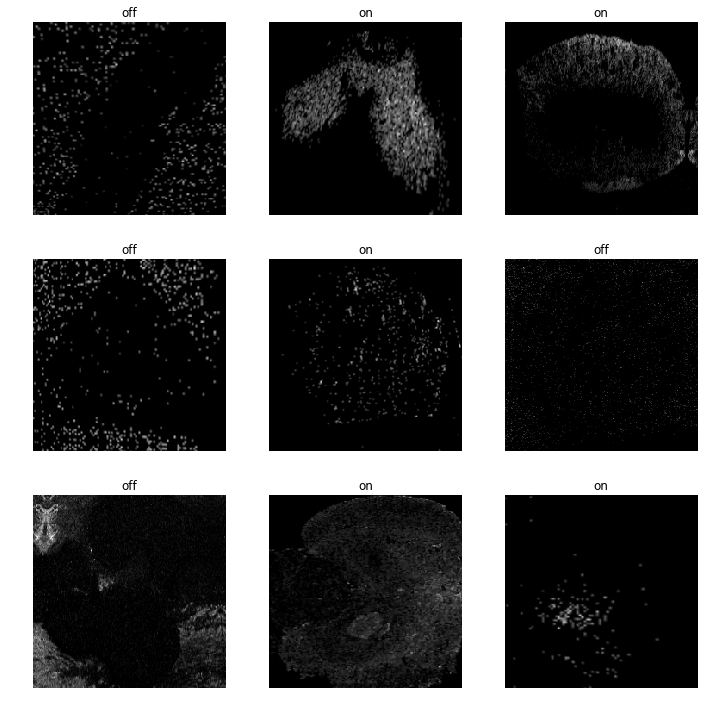

In [330]:
data.show_batch(rows=3, figsize=(10, 10))

In [278]:
data_2 = (src_2.transform(tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
# data_2 = (src_2.transform(tfms, size=128)
        .databunch()
        .normalize(imagenet_stats))

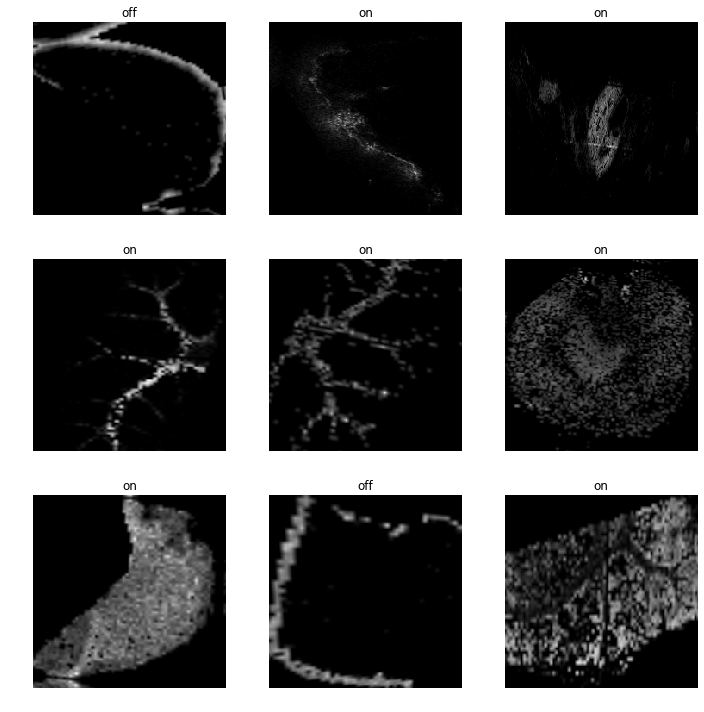

In [279]:
data_2.show_batch(rows=3, figsize=(10, 10))

***Train model***

In [345]:
arch = models.resnet50

In [346]:
learn = create_cnn(data, arch, metrics=[accuracy], ps=0.5)

In [347]:
# learn.lr_find(); learn.recorder.plot()

In [348]:
lr = 3e-3
lr, np.log10(lr)

(0.003, -2.5228787452803374)

In [349]:
learn.fit_one_cycle(5, slice(lr), wd=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.124612,0.136075,0.945011
2,0.078340,0.169842,0.946888
3,0.072464,0.104710,0.958691
4,0.059064,0.112132,0.955204
5,0.048409,0.108740,0.956545


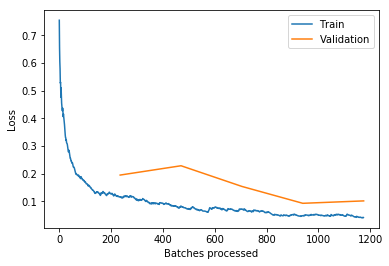

In [230]:
learn.recorder.plot_losses()

In [231]:
learn.save(f'gs-{arch.__name__}-stage1.fai')

In [236]:
learn.load(f'gs-{arch.__name__}-stage1.fai');

In [237]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


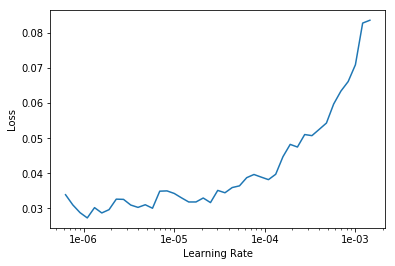

In [238]:
learn.lr_find(); learn.recorder.plot()

In [239]:
div = 100
lr/div, np.log10(lr/div)

(0.0001, -4.0)

In [240]:
learn.fit_one_cycle(5, slice(1e-6, lr/div))

epoch,train_loss,valid_loss,accuracy
1,0.043902,0.098326,0.963251
2,0.041643,0.092690,0.962983
3,0.036862,0.084452,0.969957
4,0.034135,0.096696,0.963251
5,0.034292,0.097902,0.963788


In [241]:
learn.save(f'gs-{arch.__name__}-stage2.fai')

In [171]:
# learn.recorder.plot_losses()

In [198]:
learn = create_cnn(data_2, arch, metrics=[accuracy], ps=0.75)
learn.load(f'gs-{arch.__name__}-stage2.fai');

In [199]:
y_pred, y_true = learn.get_preds(DatasetType.Valid)
accuracy_score(y_true, y_pred[:,1] > 0.5)

0.7406989853438557

In [194]:
learn.freeze()

In [195]:
# learn.lr_find(); learn.recorder.plot()

In [200]:
lr = 3e-3
learn.fit_one_cycle(5, slice(lr), wd=10.0)

epoch,train_loss,valid_loss,accuracy
1,0.335311,0.370824,0.827508
2,0.204690,0.279832,0.945885
3,0.156077,0.229903,0.951522
4,0.125103,0.177711,0.952649
5,0.109109,0.176239,0.945885


In [197]:
learn.save(f'gs-{arch.__name__}-stage3.fai')

### Full Size Images Fine-Tuning

In [141]:
learn.load('gs-rn34-stage2.fai');

In [135]:
data = (src.transform(tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='border')
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 224, 224])

In [136]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


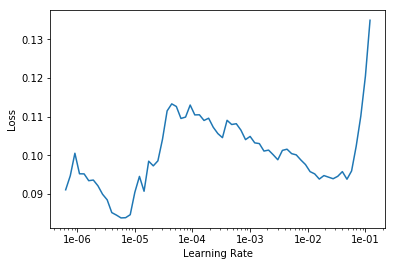

In [137]:
learn.lr_find(); learn.recorder.plot()

In [142]:
lr = 1e-3
lr, np.log10(lr)

(0.001, -3.0)

In [143]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,0.085169,0.085564,0.971552
2,0.068971,0.096758,0.969397
3,0.063691,0.092253,0.968534
4,0.063977,0.103819,0.965948
5,0.064421,0.092048,0.969397


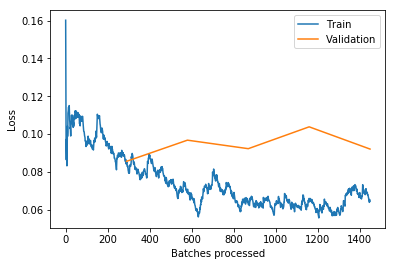

In [144]:
learn.recorder.plot_losses()

In [145]:
lr/10

0.0001

In [146]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, lr/10))

epoch,train_loss,valid_loss,accuracy
1,0.072185,0.101338,0.967241
2,0.059752,0.128073,0.957112
3,0.052710,0.102425,0.966595
4,0.046637,0.101842,0.968103
5,0.043802,0.101731,0.969181


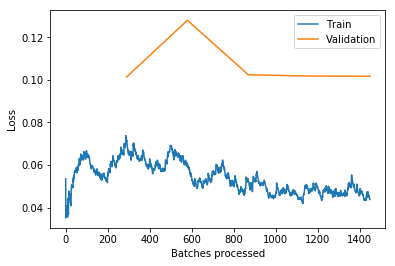

In [147]:
learn.recorder.plot_losses()

### Metrics and Interpretation

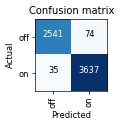

In [438]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(2, 2), dpi=60)

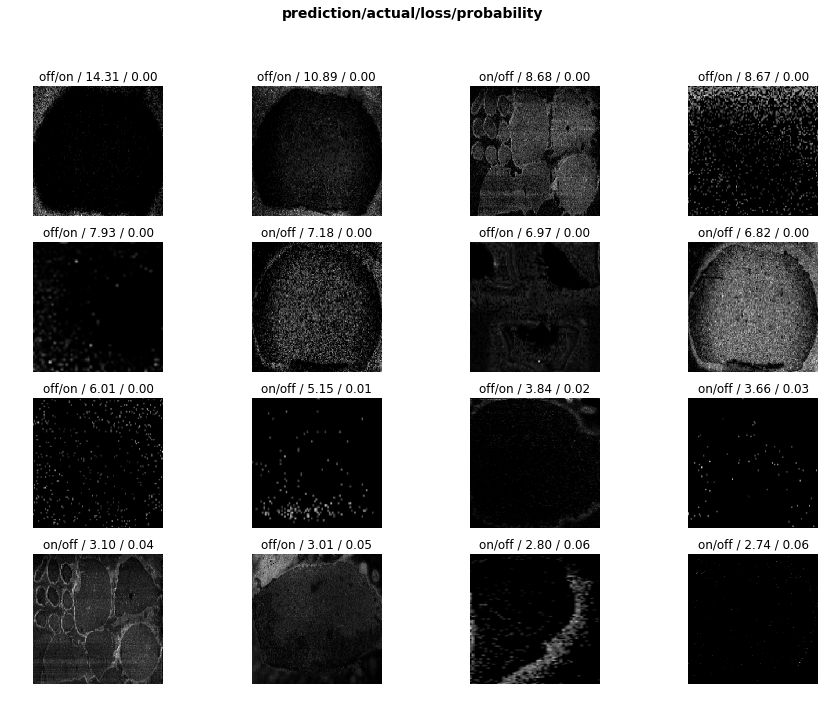

In [439]:
interp.plot_top_losses(16, figsize=(15, 11))

# Cross Validation

### Rect and Non-rect together

In [20]:
from sklearn.model_selection import GroupKFold

image_df = df

folds = 5  # number of CV folds
cv_metrics = []
ds_metrics = []

def add_metrics(learn, valid_df, fold_i, rect):
    y_pred, y_true = learn.get_preds(ds_type=DatasetType.Valid)
    metrics = calc_metrics(y_true.numpy(), y_pred.numpy())
    metrics['fold'] = fold_i
    cv_metrics.append(metrics)
    print(metrics)
    ds_metrics.append(calc_ds_metrics(valid_df, y_true, y_pred))

cv_iter = GroupKFold(n_splits=folds).split(image_df.name, groups=image_df.group)
for fold_i, (t_inds, v_inds) in enumerate(cv_iter):
    print(f'Fold: {fold_i}')

    src = (ImageItemList.from_df(image_df, '', cols=0)
           .split_by_idxs(t_inds, v_inds)
           .label_from_df(cols=2))

    tfms = get_transforms(flip_vert=True)
    data = (src.transform(tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
            .databunch().normalize(imagenet_stats))

    arch = models.resnet50
    learn = create_cnn(data, arch, metrics=[accuracy], ps=0.5)

    print('First round: head training')
    lr = 3e-3
    learn.fit_one_cycle(5, slice(lr), wd=0.1)

    print('Second round: fine-tuning')
    learn.unfreeze()
    div = 10
    learn.fit_one_cycle(5, slice(1e-5, lr/div), wd=0.1)

    add_metrics(learn, image_df.iloc[v_inds], fold_i, rect=True)

cv_metrics_df = pd.concat(cv_metrics)
ds_metrics_df = pd.concat(ds_metrics)

           f1      prec    recall       acc  fold
on   0.942303  0.967249  0.918611  0.953303     4
off  0.960781  0.944227  0.977925  0.953303     4


In [21]:
cv_metrics_df.groupby([cv_metrics_df.index]).agg([np.mean, np.std])

f1                prec              recall                 acc  \
         mean       std      mean       std      mean       std      mean   
off  0.970932  0.005894  0.961989  0.017145  0.980422  0.015093  0.966081   
on   0.956637  0.018119  0.973997  0.014092  0.940477  0.034016  0.966081   

              fold            
          std mean       std  
off  0.009449    2  1.581139  
on   0.009449    2  1.581139

In [26]:
ds_metrics_df

,f1,prec,recall,acc,ds_name
on,1.000000,1.000000,1.000000,1.000000,161007_WT1S1L1
off,1.000000,1.000000,1.000000,1.000000,161007_WT1S1L1
on,0.905660,1.000000,0.827586,0.929178,170321_kangaroobrain-bpyn1-pos_maxof50.0_med1r
off,0.943311,0.892704,1.000000,0.929178,170321_kangaroobrain-bpyn1-pos_maxof50.0_med1r
on,0.994012,0.988095,1.000000,0.991453,2017023_ADP_GFlarvae_55x55_40x40_DMAN002
off,0.985075,1.000000,0.970588,0.991453,2017023_ADP_GFlarvae_55x55_40x40_DMAN002
on,0.928910,1.000000,0.867257,0.959569,20180220_mouse eye_DHB
off,0.971751,0.945055,1.000000,0.959569,20180220_mouse eye_DHB
on,0.993421,0.993421,0.993421,0.994083,50%meoh_8cyc_75um
off,0.994624,0.994624,0.994624,0.994083,50%meoh_8cyc_75um


### Rect and Non-rect Separately

In [350]:
from sklearn.model_selection import GroupKFold

image_df = df

folds = 5  # number of CV folds
cv_metrics = []
ds_metrics = []

def add_metrics(learn, valid_df, fold_i, rect):
    y_pred, y_true = learn.get_preds(ds_type=DatasetType.Valid)
    metrics = calc_metrics(y_true.numpy(), y_pred.numpy())
    metrics['fold'] = fold_i
    metrics['rect'] = rect
    cv_metrics.append(metrics)
    print(metrics)
    ds_metrics.append(calc_ds_metrics(valid_df, y_true, y_pred))

rect_df = image_df[image_df.rect == True]
nonrect_df = image_df[image_df.rect == False]

cv_iter = zip(GroupKFold(n_splits=folds).split(rect_df.name, groups=rect_df.group),
              GroupKFold(n_splits=folds).split(nonrect_df.name, groups=nonrect_df.group))
for fold_i, ((t_inds, v_inds), (t_inds_2, v_inds_2)) in enumerate(cv_iter):
    print(f'Fold: {fold_i}')

    src = (ImageItemList.from_df(rect_df, '', cols=0)
           .split_by_idxs(t_inds, v_inds)
           .label_from_df(cols=2))
    src_2 = (ImageItemList.from_df(nonrect_df, '', cols=0)
             .split_by_idxs(t_inds_2, v_inds_2)
             .label_from_df(cols=2))

    tfms = get_transforms(flip_vert=True)
    data = (src.transform(tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
            .databunch().normalize(imagenet_stats))
    data_2 = (src_2.transform(tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
              .databunch().normalize(imagenet_stats))

    arch = models.resnet50
    learn = create_cnn(data, arch, metrics=[accuracy], ps=0.5)

    print('First round: head training')
    lr = 3e-3
    learn.fit_one_cycle(5, slice(lr), wd=0.1)

    print('Second round: fine-tuning')
    learn.unfreeze()
    div = 10
    learn.fit_one_cycle(5, slice(1e-5, lr/div), wd=0.1)

    add_metrics(learn, rect_df.iloc[v_inds], fold_i, rect=True)

    print('Third round: non-rect head training')
    learn = create_cnn(data_2, arch, metrics=[accuracy], ps=0.75)
    learn.load(f'gs-{arch.__name__}-stage2.fai');
    learn.freeze()
    lr = 3e-3
    learn.fit_one_cycle(5, slice(lr), wd=10.0)

    add_metrics(learn, nonrect_df.iloc[v_inds_2], fold_i, rect=False)

cv_metrics_df = pd.concat(cv_metrics)
ds_metrics_df = pd.concat(ds_metrics)

           f1      prec    recall       acc  fold   rect
on   0.970033  0.995444  0.945887  0.969799     4  False
off  0.969560  0.945055  0.995370  0.969799     4  False


In [356]:
cv_metrics_df.groupby([cv_metrics_df.index]).agg([np.mean, np.std])

f1               prec              recall                 acc  \
         mean       std     mean       std      mean       std      mean   
off  0.964898  0.017305  0.95212  0.029331  0.978592  0.017410  0.954983   
on   0.929768  0.060157  0.95887  0.038442  0.905715  0.089893  0.954983   

              fold           rect            
          std mean       std mean       std  
off  0.027243    2  1.490712  0.5  0.527046  
on   0.027243    2  1.490712  0.5  0.527046

In [357]:
cv_metrics_df.groupby([cv_metrics_df.rect, cv_metrics_df.index]).agg([np.mean, np.std])

f1                prec              recall            \
               mean       std      mean       std      mean       std   
rect                                                                    
False off  0.954266  0.012971  0.931460  0.016895  0.978414  0.016343   
      on   0.892876  0.065579  0.947399  0.043886  0.847540  0.094295   
True  off  0.975531  0.014931  0.972780  0.024150  0.978770  0.020367   
      on   0.966660  0.020956  0.970340  0.032713  0.963889  0.028799   

                acc           fold            
               mean       std mean       std  
rect                                          
False off  0.937960  0.025447    2  1.581139  
      on   0.937960  0.025447    2  1.581139  
True  off  0.972005  0.017259    2  1.581139  
      on   0.972005  0.017259    2  1.581139

In [17]:
# ds_metrics_df

---